# Rs(T) vs B

In [18]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import warnings
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

In [19]:
def calculate_sheet_resistance_vdp(R_A, R_B, delta=0.0005, max_iterations=10000) -> float:
    # Initial z_i, or z_0
    z_prev = (2 * np.log(2)) / (np.pi * (R_A + R_B))

    iterations = 0
    while iterations < max_iterations:
        # y_i
        # Using 1/exp(x) which is equivalent to exp(-x) for numerical stability
        y_i = np.exp(-np.pi * z_prev * R_A) + np.exp(-np.pi * z_prev * R_B)

        # z_i
        numerator = (1 - y_i) / np.pi
        denominator = (R_A * np.exp(-np.pi * z_prev * R_A) + R_B * np.exp(-np.pi * z_prev * R_B))

        if abs(denominator) < 1e-18: # A small threshold to prevent division by zero
            print(f"Warning: Denominator in z_i calculation is too small. R_A={R_A}, R_B={R_B}. Stopping.")
            return np.nan
        
        z_curr = z_prev - (numerator / denominator)

        # Check for convergence
        if z_curr == 0: # Avoid division by zero if z_curr becomes 0
            if z_prev == 0: # If both are zero, it's converged to zero
                break
            else: # If z_curr is zero but z_prev isn't, the relative change is infinite
                # This indicates a potential issue or Rs becoming infinitely large, meaning bad R_A, R_B
                print(f"Warning: z_curr became 0. R_A={R_A}, R_B={R_B}. Stopping.")
                return np.nan

        relative_change = abs((z_curr - z_prev) / z_curr)

        if relative_change < delta:
            R_s = 1 / z_curr
            return R_s

        z_prev = z_curr
        iterations += 1

    print(f"Warning: Calculation did not converge within {max_iterations} iterations for R_A={R_A}, R_B={R_B}.")
    return np.nan

Read the data

In [20]:
# --- Parameters ---
#data_dir = "C:/Users/fzana/OneDrive/Desktop/quantum engineering/Advanced experimental physics/Nb-Characterization/SUPERCONDUCTIVITY/DataSets"  # Change to your directory if needed
data_dir = "./DataSets/"
file_pattern = os.path.join(data_dir, "2025-04-08_VdP_B*T.dat")
intra_cutoff = 0       
inter_cutoff = 0       

# --- Column indices (0-based) ---
columns_to_read = [5, 6, 7, 16, 17, 18]  # front_temp, front_temp_fluct, front_R, back_temp, back_temp_fluct, back_R

# --- Store results ---
raw_data = {}
filtered_data = {}

# --- Loop over all files ---
for filepath in sorted(glob.glob(file_pattern)):
    # Extract the x value from the filename
    basename = os.path.basename(filepath)
    try:
        x_str = basename.split("B")[-1].split("T.dat")[0]
        x_key = x_str.replace('.', '_')  # For variable safety
        x_val = float(x_str)
    except Exception as e:
        print(f"Skipping file {basename} due to parsing error: {e}")
        continue

    # Load the required columns only
    try:
        data = pd.read_csv(filepath, sep=r'\s+', header=None, usecols=columns_to_read)
        data.columns = ['front_temp', 'front_temp_fluct', 'front_R', 'back_temp', 'back_temp_fluct', 'back_R']
    except Exception as e:
        print(f"Error reading {basename}: {e}")
        continue

    # Store raw values
    for col in data.columns:
        raw_data[f"{col}_raw_{x_str}"] = data[col].copy()

    # Compute average temperature
    #avg_temp = (data['front_temp'] + data['back_temp']) / 2

    # Mask
    sel_mask = (
        (data['front_R'] > 0) & (data['back_R'] > 0) &
        (data['front_temp_fluct'] <= intra_cutoff) &
        (data['back_temp_fluct'] <= intra_cutoff) &
        (abs(data['front_temp'] - data['back_temp']) == inter_cutoff)
    )

    # Apply mask and store filtered values
    filtered_data[f"Rf_{x_str}"] = data['front_R'][sel_mask].values
    filtered_data[f"Rb_{x_str}"] = data['back_R'][sel_mask].values
    #filtered_data[f"Tavg_{x_str}"] = avg_temp[sel_mask].values
    filtered_data[f"Tf_{x_str}"] = data['front_temp'][sel_mask].values
    filtered_data[f"Tb_{x_str}"] = data['back_temp'][sel_mask].values

print("Processing complete. Variables are stored in raw_data and filtered_data dictionaries.")
print(filtered_data.keys())

Skipping file 2025-04-08_VdP_B_from_0.4_to_0T.dat due to parsing error: could not convert string to float: '_from_0.4_to_0'
Processing complete. Variables are stored in raw_data and filtered_data dictionaries.
dict_keys(['Rf_0.4', 'Rb_0.4', 'Tf_0.4', 'Tb_0.4', 'Rf_0.8', 'Rb_0.8', 'Tf_0.8', 'Tb_0.8', 'Rf_0', 'Rb_0', 'Tf_0', 'Tb_0', 'Rf_1.6', 'Rb_1.6', 'Tf_1.6', 'Tb_1.6', 'Rf_2.4', 'Rb_2.4', 'Tf_2.4', 'Tb_2.4', 'Rf_3.2', 'Rb_3.2', 'Tf_3.2', 'Tb_3.2', 'Rf_3.6', 'Rb_3.6', 'Tf_3.6', 'Tb_3.6', 'Rf_3.8', 'Rb_3.8', 'Tf_3.8', 'Tb_3.8', 'Rf_4.0', 'Rb_4.0', 'Tf_4.0', 'Tb_4.0'])


In [21]:
# --- Compute and store sheet resistance Rs for each x ---
for key in list(filtered_data.keys()):
    if key.startswith("Rf_"):
        x_str = key.split("_")[1]

        Rf_vals = filtered_data[f"Rf_{x_str}"]
        Rb_vals = filtered_data[f"Rb_{x_str}"]

        if len(Rf_vals) != len(Rb_vals):
            print(f"Length mismatch for x = {x_str}. Skipping Rs computation.")
            continue

        # Calculate sheet resistance for each pair
        Rs_vals = np.array([
            calculate_sheet_resistance_vdp(R_A, R_B)
            for R_A, R_B in zip(Rf_vals, Rb_vals)
        ])

        filtered_data[f"Rs_{x_str}"] = Rs_vals

print(filtered_data.keys())


dict_keys(['Rf_0.4', 'Rb_0.4', 'Tf_0.4', 'Tb_0.4', 'Rf_0.8', 'Rb_0.8', 'Tf_0.8', 'Tb_0.8', 'Rf_0', 'Rb_0', 'Tf_0', 'Tb_0', 'Rf_1.6', 'Rb_1.6', 'Tf_1.6', 'Tb_1.6', 'Rf_2.4', 'Rb_2.4', 'Tf_2.4', 'Tb_2.4', 'Rf_3.2', 'Rb_3.2', 'Tf_3.2', 'Tb_3.2', 'Rf_3.6', 'Rb_3.6', 'Tf_3.6', 'Tb_3.6', 'Rf_3.8', 'Rb_3.8', 'Tf_3.8', 'Tb_3.8', 'Rf_4.0', 'Rb_4.0', 'Tf_4.0', 'Tb_4.0', 'Rs_0.4', 'Rs_0.8', 'Rs_0', 'Rs_1.6', 'Rs_2.4', 'Rs_3.2', 'Rs_3.6', 'Rs_3.8', 'Rs_4.0'])


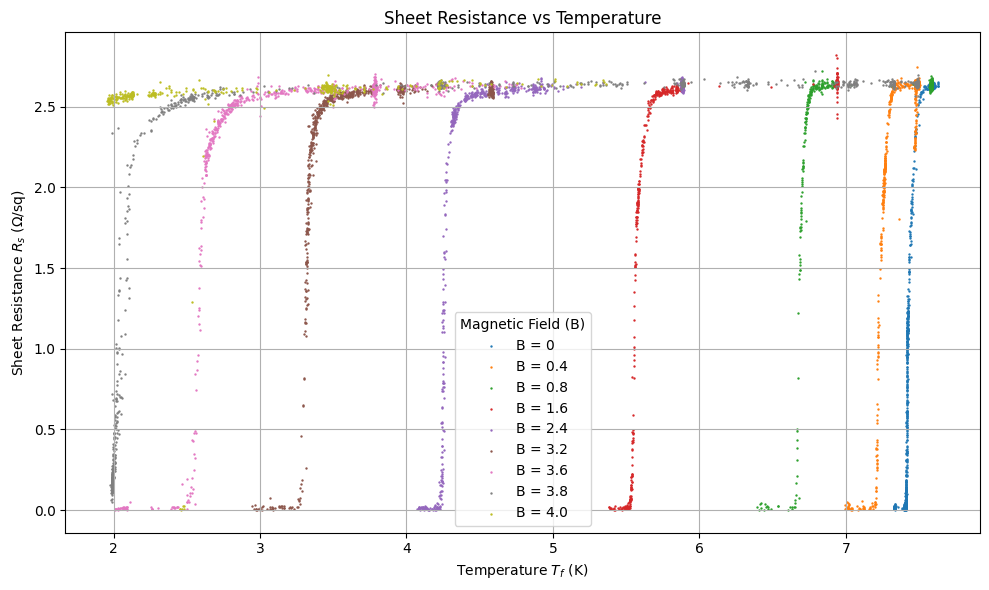

In [22]:
# --- Plot all Rs_x vs Tf_x as scatter plots in one figure ---
plt.figure(figsize=(10, 6))

for key in sorted(filtered_data.keys()):
    if key.startswith("Rs_"):
        x_str = key.split("_")[1]
        Rs_vals = filtered_data[key]
        Tf_key = f"Tf_{x_str}"

        # Check if Tf_x exists
        if Tf_key not in filtered_data:
            print(f"Missing {Tf_key} for plotting Rs_{x_str}, skipping.")
            continue

        Tf_vals = filtered_data[Tf_key]

        if len(Rs_vals) != len(Tf_vals):
            print(f"Length mismatch for Rs_{x_str} and Tf_{x_str}, skipping.")
            continue

        # # Sort values for cleaner plotting
        # sorted_indices = np.argsort(Tf_vals)
        # Tf_sorted = Tf_vals[sorted_indices]
        # Rs_sorted = Rs_vals[sorted_indices]

        # Scatter plot
        plt.scatter(Tf_vals, Rs_vals, label=f"B = {x_str}", s=.5)

# Plot formatting
plt.xlabel("Temperature $T_f$ (K)")
plt.ylabel("Sheet Resistance $R_s$ (Ω/sq)")
plt.title("Sheet Resistance vs Temperature")
plt.legend(title="Magnetic Field (B)")
plt.grid(True)
plt.tight_layout()
plt.show()

# **$T_C$ Evaluation**

## **50-90-10 Method**

### $T_C$ with raw data

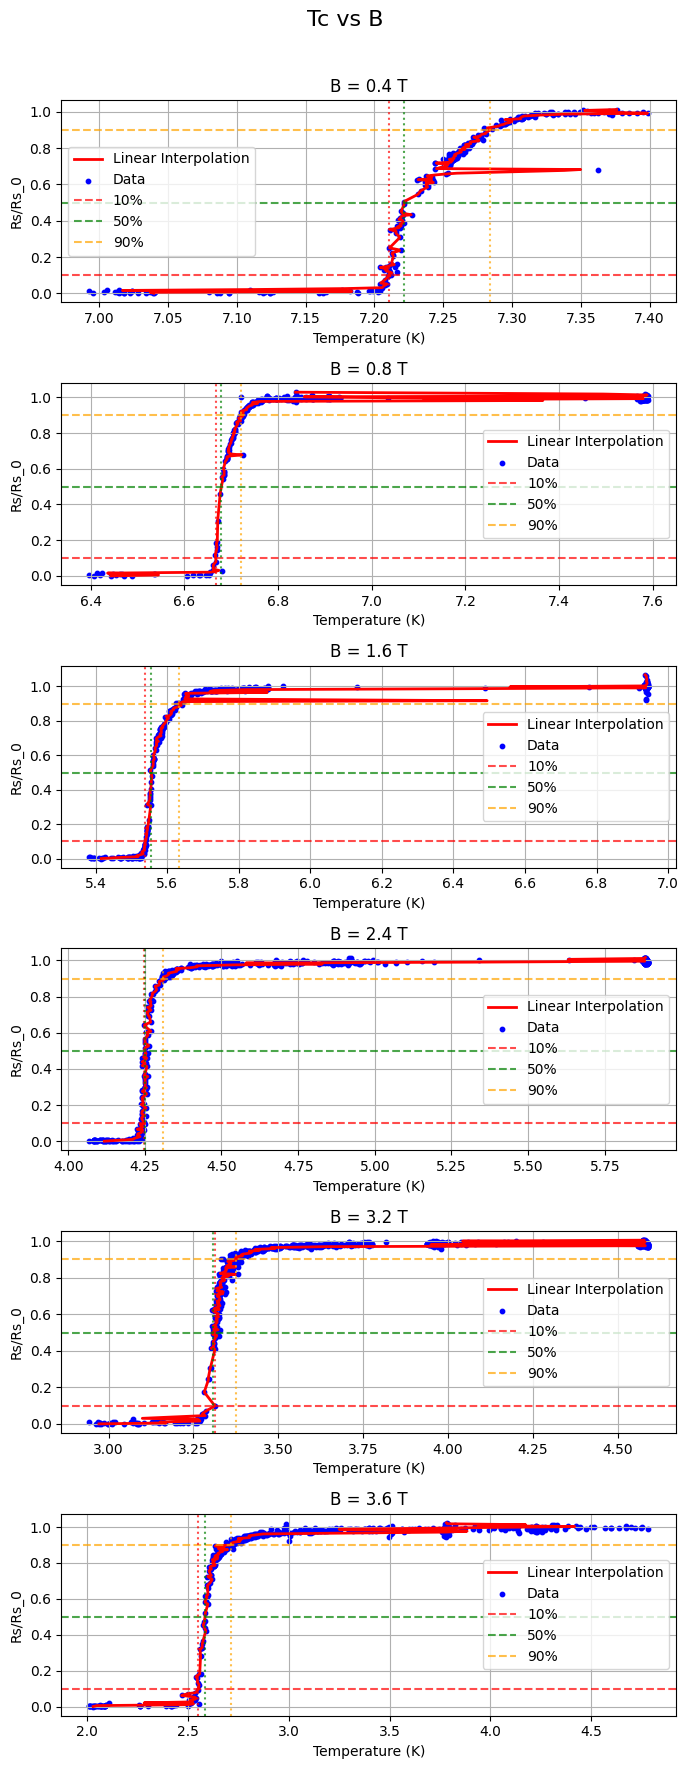

[array(7.22146758), array(6.67893477), array(5.55421816), array(4.25070943), array(3.30845614), array(2.5841235)]
[0.03666391434780003, 0.026997290645912386, 0.046845899337540686, 0.029808158435620236, 0.030608197574264695, 0.08038448892985262]


In [34]:
# --- X values from your original dataset names ---
B_vals = [0.4, 0.8, 1.6, 2.4, 3.2, 3.6]
Tc_vals = []
Tc_uncertainties = []
Rs_0 = 2.64270235
Rs_0_uncertainty = 0.4624039

threshold_10 = 0.1
threshold_50 = 0.5  
threshold_90 = 0.9

# --- Plotting ---
fig, axs = plt.subplots(len(B_vals), 1, figsize=(7, 3 * len(B_vals)), sharex=False)
fig.suptitle("Tc vs B", fontsize=16)



for i, x in enumerate(B_vals):
    try:
        Tf = filtered_data[f'Tf_{x}']
        Rs = filtered_data[f'Rs_{x}']
    except KeyError:
        print(f"Missing data for x={x}, skipping...")
        continue

    if x == 0.4:
        mask_Tf_below_7_4 = Tf < 7.4
        Tf = Tf[mask_Tf_below_7_4]
        Rs = Rs[mask_Tf_below_7_4]

    sorted_indices = np.argsort(Tf)
    Tf = Tf[sorted_indices]
    Rs = Rs[sorted_indices]

    R_norm = Rs / Rs_0

    interp_func = interp1d(R_norm, Tf, kind='linear',
                          bounds_error=False, fill_value='extrapolate')
    
    T_10 = interp_func(threshold_10)
    T_50 = interp_func(threshold_50)
    T_90 = interp_func(threshold_90)

    if np.isnan(T_10) or np.isnan(T_50) or np.isnan(T_90):
        print(f"Warning: Interpolation failed for B = {x}")

    Tc = T_50
    uncertainty = (T_90 - T_10) / 2

    result = {
        'Tc': Tc,
        'uncertainty': uncertainty,
        'T_10': T_10,
        'T_50': T_50,
        'T_90': T_90,
        'Rs_0': Rs_0,
        'B_field': x
    }

    Tc_vals.append(result['Tc'])
    Tc_uncertainties.append(result['uncertainty'])


    ax_r = axs[i]

    # Plot the interpolation function
    # Ensure R_norm_plot_grid is monotonically increasing for interp_func to work correctly
    min_R_norm = np.min(R_norm)
    max_R_norm = np.max(R_norm)
    R_norm_plot_grid = np.linspace(min_R_norm, max_R_norm, 200)
    
    # Evaluate the interp_func on this fine grid to get corresponding temperatures
    Tf_interpolated = interp_func(R_norm_plot_grid)
    
    # Plot the interpolated curve: x-axis is Tf_interpolated, y-axis is R_norm_plot_grid
    ax_r.plot(Tf_interpolated, R_norm_plot_grid, color='red', linestyle='-', linewidth=2, label="Linear Interpolation")
    ax_r.scatter(Tf, R_norm, color='blue', s=10, label="Data")
    ax_r.axhline(y=threshold_10, color='r', linestyle='--', alpha=0.7, label='10%')
    ax_r.axhline(y=threshold_50, color='g', linestyle='--', alpha=0.7, label='50%')
    ax_r.axhline(y=threshold_90, color='orange', linestyle='--', alpha=0.7, label='90%')
    ax_r.axvline(x=T_10, color='r', linestyle=':', alpha=0.7)
    ax_r.axvline(x=T_50, color='g', linestyle=':', alpha=0.7)
    ax_r.axvline(x=T_90, color='orange', linestyle=':', alpha=0.7)
    ax_r.set_ylabel("Rs/Rs_0")
    ax_r.set_xlabel("Temperature (K)")
    ax_r.set_title(f"B = {x} T")
    ax_r.legend()
    ax_r.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

print(Tc_vals)
print(Tc_uncertainties)

### $T_{zero}$ and $T_{on}$

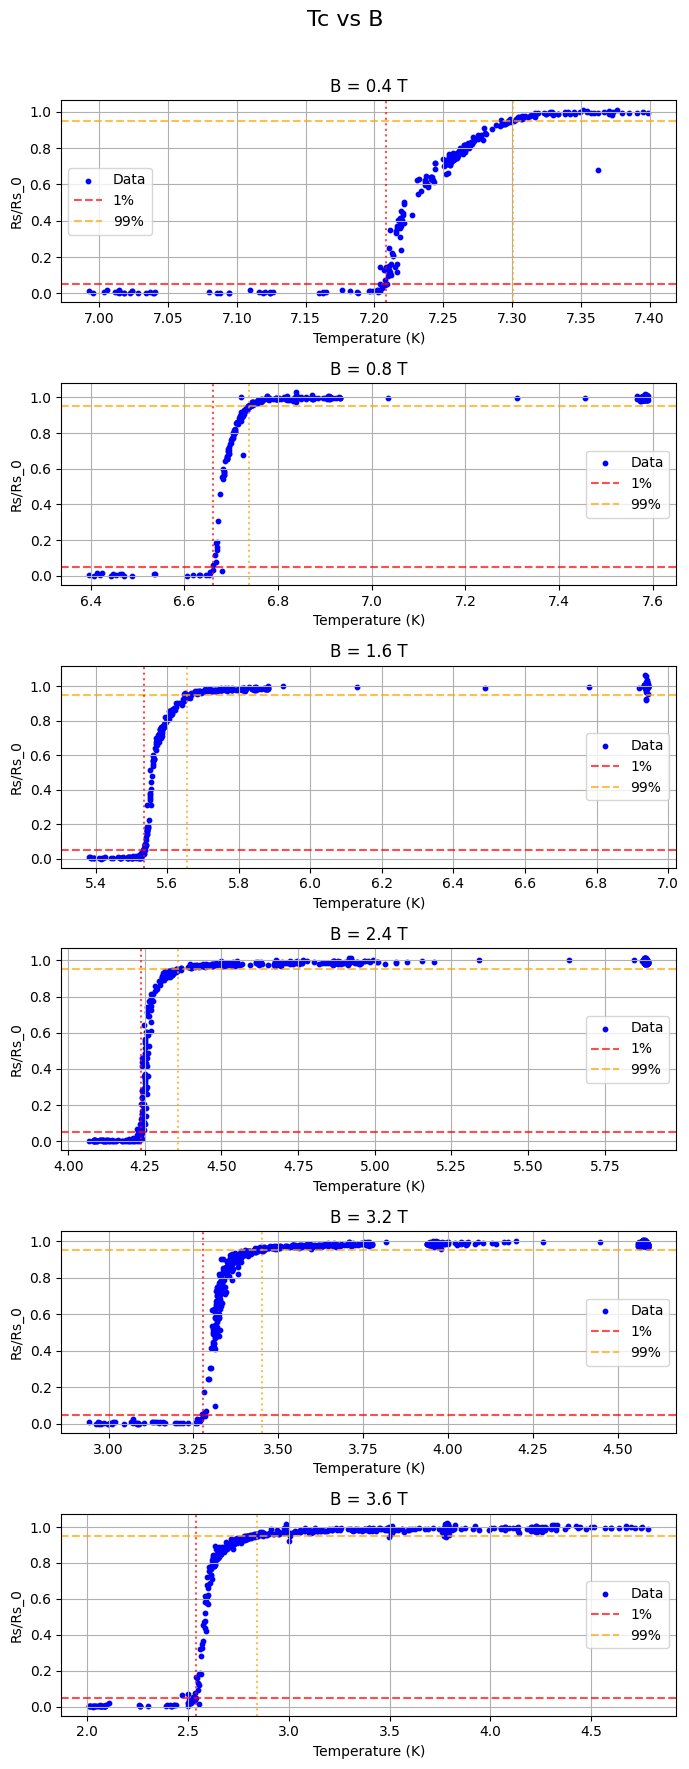

[array(7.20872114), array(6.661751), array(5.53502263), array(4.23870407), array(3.27842976), array(2.53942075)]
[array(7.3007394), array(6.73878433), array(5.6558971), array(4.35967951), array(3.45306136), array(2.84047075)]


In [41]:
# --- X values from your original dataset names ---
B_vals = [0.4, 0.8, 1.6, 2.4, 3.2, 3.6]
T001_vals = []
T099_vals = []
Rs_0 = 2.64270235
Rs_0_uncertainty = 0.4624039

threshold_001 = 0.05  
threshold_099 = 0.95

# --- Plotting ---
fig, axs = plt.subplots(len(B_vals), 1, figsize=(7, 3 * len(B_vals)), sharex=False)
fig.suptitle("Tc vs B", fontsize=16)

for i, x in enumerate(B_vals):
    try:
        Tf = filtered_data[f'Tf_{x}']
        Rs = filtered_data[f'Rs_{x}']
    except KeyError:
        print(f"Missing data for x={x}, skipping...")
        continue

    if x == 0.4:
        mask_Tf_below_7_4 = Tf < 7.4
        Tf = Tf[mask_Tf_below_7_4]
        Rs = Rs[mask_Tf_below_7_4]

    R_norm = Rs / Rs_0

    interp_func = interp1d(R_norm, Tf, kind='linear',
                          bounds_error=False, fill_value='extrapolate')
    
    T_001 = interp_func(threshold_001)
    T_099 = interp_func(threshold_099)

    if np.isnan(T_001) or np.isnan(T_099):
        print(f"Warning: Interpolation failed for B = {x}")

    result = {
        'uncertainty': uncertainty,
        'T_001': T_001,
        'T_099': T_099,
        'Rs_0': Rs_0,
        'B_field': x
    }

    T001_vals.append(result['T_001'])
    T099_vals.append(result['T_099'])

    # --- Plot Rs(T) ---
    ax_r = axs[i]
    ax_r.scatter(Tf, R_norm, color='blue', s=10, label="Data")
    ax_r.axhline(y=threshold_001, color='r', linestyle='--', alpha=0.7, label='1%')
    ax_r.axhline(y=threshold_099, color='orange', linestyle='--', alpha=0.7, label='99%')
    ax_r.axvline(x=T_001, color='r', linestyle=':', alpha=0.7)
    ax_r.axvline(x=T_099, color='orange', linestyle=':', alpha=0.7)
    ax_r.set_ylabel("Rs/Rs_0")
    ax_r.set_xlabel("Temperature (K)")
    ax_r.set_title(f"B = {x} T")
    ax_r.legend()
    ax_r.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

print(T001_vals)
print(T099_vals)

### Phase Diagram

Initial guesses for fit: Bc2(0)=5.40, Tc_MF=7.22

Fitted EGL Parameters:
  Bc2(0) = 4.4641 +/- 0.0423 T
  Tc^MF  = 7.9568 +/- 0.0438 K


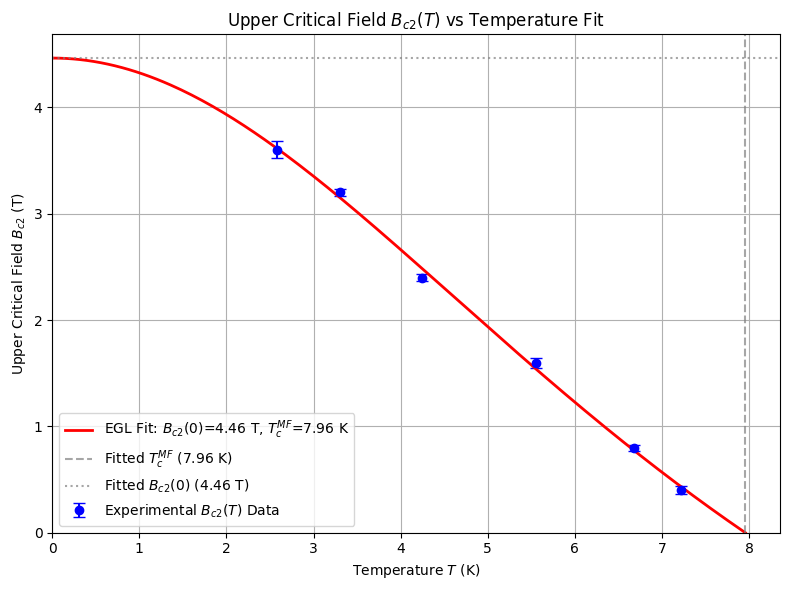

In [ ]:
# --- Define the Extended Ginzburg-Landau (EGL) function to fit ---
def egl_model(T, Bc2_0, Tc_MF):
    # Ensure T is not exactly Tc_MF to avoid division by zero in t^2/1+t^2
    # Also handle cases where T > Tc_MF as Bc2 should be 0 there.
    T_non_zero_check = np.where(T >= Tc_MF, Tc_MF - 1e-9, T) # Small offset for T near Tc_MF

    t = T_non_zero_check / Tc_MF

    result = np.where(t < 1, Bc2_0 * (1 - t**2) / (1 + t**2), 0.0)
    
    return result

# 1. Bc2_0:
#    A good guess is the highest B_val.
initial_Bc2_0_guess = np.max(B_vals) * 1.5 # Guess it's a bit higher than max measured B
# 2. Tc_MF:
#    A good guess is the Tc(B=0.4).
initial_Tc_MF_guess = Tc_vals[np.argmin(B_vals)]

initial_guess = [initial_Bc2_0_guess, initial_Tc_MF_guess]

print(f"Initial guesses for fit: Bc2(0)={initial_Bc2_0_guess:.2f}, Tc_MF={initial_Tc_MF_guess:.2f}")

# --- Perform the Curve Fit ---
try:
    popt, pcov = curve_fit(egl_model, Tc_vals, B_vals, p0=initial_guess, sigma=Tc_uncertainties, absolute_sigma=True)

    Bc2_0_fit, Tc_MF_fit = popt
    
    # Calculate standard errors of the fitted parameters
    perr = np.sqrt(np.diag(pcov))
    Bc2_0_err, Tc_MF_err = perr

    print(f"\nFitted EGL Parameters:")
    print(f"  Bc2(0) = {Bc2_0_fit:.4f} +/- {Bc2_0_err:.4f} T")
    print(f"  Tc^MF  = {Tc_MF_fit:.4f} +/- {Tc_MF_err:.4f} K")

    # --- Generate the Fitted Curve for Plotting ---
    # Create a fine grid of temperatures from 0 up to Tc_MF
    T_fit_curve = np.linspace(0, Tc_MF_fit, 200)
    Bc2_fit_curve = egl_model(T_fit_curve, Bc2_0_fit, Tc_MF_fit)

except RuntimeError as e:
    print(f"Error: Could not fit the EGL model. {e}")
    Bc2_0_fit, Tc_MF_fit = initial_guess # Use initial guess for plotting if fit fails
    T_fit_curve = np.linspace(0, initial_Tc_MF_guess * 1.1, 200)
    Bc2_fit_curve = egl_model(T_fit_curve, initial_Bc2_0_guess, initial_Tc_MF_guess)
    perr = [np.nan, np.nan] # Indicate errors are not available

# --- Plotting the Data and Fit ---
plt.figure(figsize=(8, 6))

# Plot experimental data with error bars
plt.errorbar(Tc_vals, B_vals, yerr=Tc_uncertainties, fmt='o', color='blue', capsize=4, label="Experimental $B_{c2}(T)$ Data")

# Plot the fitted EGL curve
plt.plot(T_fit_curve, Bc2_fit_curve, color='red', linestyle='-', linewidth=2,
         label=f"EGL Fit: $B_{{c2}}(0)$={Bc2_0_fit:.2f} T, $T_c^{{MF}}$={Tc_MF_fit:.2f} K")

# Add a dashed line for the fitted Tc_MF
plt.axvline(x=Tc_MF_fit, color='gray', linestyle='--', alpha=0.7, label=f"Fitted $T_c^{{MF}}$ ({Tc_MF_fit:.2f} K)")
plt.axhline(y=Bc2_0_fit, color='gray', linestyle=':', alpha=0.7, label=f"Fitted $B_{{c2}}(0)$ ({Bc2_0_fit:.2f} T)")


plt.xlabel("Temperature $T$ (K)")
plt.ylabel("Upper Critical Field $B_{c2}$ (T)")
plt.title("Upper Critical Field $B_{c2}(T)$ vs Temperature Fit")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0) 
plt.xlim(left=0) 
plt.tight_layout()
plt.show()

Initial guesses (T001): Bc2(0)=5.40, Tc_MF=7.21
Fitted Parameters (T001):
  Bc2(0) = 4.4368 +/- 0.0603 T
  Tc^MF  = 7.9574 +/- 0.0738 K
Initial guesses (T099): Bc2(0)=5.40, Tc_MF=7.30
Fitted Parameters (T099):
  Bc2(0) = 4.6185 +/- 0.0708 T
  Tc^MF  = 7.9987 +/- 0.0790 K


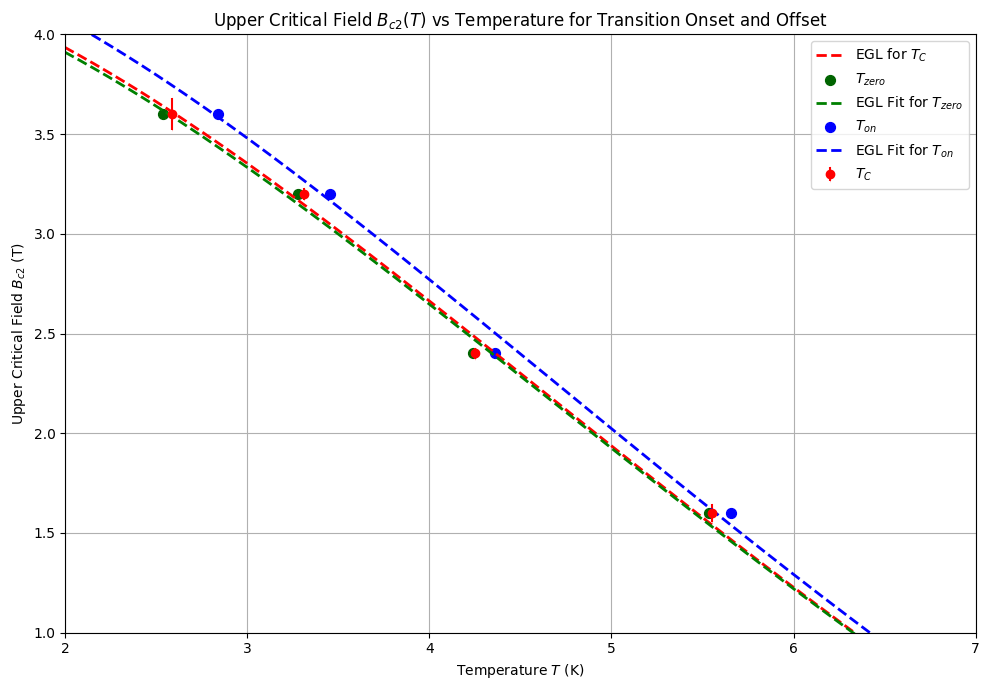

  Tc^MF (Transition Begins, T001): 7.9574 +/- 0.0738 K
  Tc^MF (Transition Ends, T099):   7.9987 +/- 0.0790 K


In [64]:
# --- --- Fit for T001_vals (Beginning of Transition) --- ---

# Initial Guesses for T001_vals fit
# Bc2_0_guess: Max B_val, slightly extended
initial_Bc2_0_guess_001 = np.max(B_vals) * 1.5
# Tc_MF_guess: T001_val at B=0
initial_Tc_MF_guess_001 = T001_vals[np.argmin(B_vals)]

initial_guess_001 = [initial_Bc2_0_guess_001, initial_Tc_MF_guess_001]
print(f"Initial guesses (T001): Bc2(0)={initial_Bc2_0_guess_001:.2f}, Tc_MF={initial_Tc_MF_guess_001:.2f}")

try:
    popt_001, pcov_001 = curve_fit(egl_model, T001_vals, B_vals, p0=initial_guess_001)
    Bc2_0_001_fit, Tc_MF_001_fit = popt_001
    perr_001 = np.sqrt(np.diag(pcov_001))
    Bc2_0_001_err, Tc_MF_001_err = perr_001

    print(f"Fitted Parameters (T001):")
    print(f"  Bc2(0) = {Bc2_0_001_fit:.4f} +/- {Bc2_0_001_err:.4f} T")
    print(f"  Tc^MF  = {Tc_MF_001_fit:.4f} +/- {Tc_MF_001_err:.4f} K")

except RuntimeError as e:
    print(f"Error fitting T001_vals: {e}")
    Bc2_0_001_fit, Tc_MF_001_fit = initial_guess_001
    perr_001 = [np.nan, np.nan] # Indicate errors are not available

# --- --- Fit for T099_vals (End of Transition) --- ---

# Initial Guesses for T099_vals fit
# Bc2_0_guess: Same logic as T001
initial_Bc2_0_guess_099 = np.max(B_vals) * 1.5
# Tc_MF_guess: T099_val at B=0
initial_Tc_MF_guess_099 = T099_vals[np.argmin(B_vals)]

initial_guess_099 = [initial_Bc2_0_guess_099, initial_Tc_MF_guess_099]
print(f"Initial guesses (T099): Bc2(0)={initial_Bc2_0_guess_099:.2f}, Tc_MF={initial_Tc_MF_guess_099:.2f}")

try:
    popt_099, pcov_099 = curve_fit(egl_model, T099_vals, B_vals, p0=initial_guess_099)
    Bc2_0_099_fit, Tc_MF_099_fit = popt_099
    perr_099 = np.sqrt(np.diag(pcov_099))
    Bc2_0_099_err, Tc_MF_099_err = perr_099

    print(f"Fitted Parameters (T099):")
    print(f"  Bc2(0) = {Bc2_0_099_fit:.4f} +/- {Bc2_0_099_err:.4f} T")
    print(f"  Tc^MF  = {Tc_MF_099_fit:.4f} +/- {Tc_MF_099_err:.4f} K")

except RuntimeError as e:
    print(f"Error fitting T099_vals: {e}")
    Bc2_0_099_fit, Tc_MF_099_fit = initial_guess_099
    perr_099 = [np.nan, np.nan] # Indicate errors are not available

# --- Generate Fitted Curves for Plotting ---
T_fine_plot_001 = np.linspace(0, max(Tc_MF_001_fit, initial_Tc_MF_guess_001), 200)
Bc2_fit_curve_001 = egl_model(T_fine_plot_001, Bc2_0_001_fit, Tc_MF_001_fit)

T_fine_plot_099 = np.linspace(0, max(Tc_MF_099_fit, initial_Tc_MF_guess_099), 200)
Bc2_fit_curve_099 = egl_model(T_fine_plot_099, Bc2_0_099_fit, Tc_MF_099_fit)


# --- Plotting the Data and Fits ---
plt.figure(figsize=(10, 7))

#PLOT TC
plt.errorbar(Tc_vals, B_vals, yerr=Tc_uncertainties, fmt='o', color='red', capsize=.1, label="$T_C$")
plt.plot(T_fit_curve, Bc2_fit_curve, color='red', linestyle='--', linewidth=2,
         label="EGL for $T_C$")

# Plot TZERO
plt.scatter(T001_vals, B_vals, color='darkgreen', s=50, label="$T_{zero}$")
plt.plot(T_fine_plot_001, Bc2_fit_curve_001, color='green', linestyle='--', linewidth=2,
         label="EGL Fit for $T_{zero}$")

# Plot TON
plt.scatter(T099_vals, B_vals, color='blue', s=50, label="$T_{on}$")
plt.plot(T_fine_plot_099, Bc2_fit_curve_099, color='blue', linestyle='--', linewidth=2,
         label="EGL Fit for $T_{on}$")

plt.xlabel("Temperature $T$ (K)")
plt.ylabel("Upper Critical Field $B_{c2}$ (T)")
plt.title("Upper Critical Field $B_{c2}(T)$ vs Temperature for Transition Onset and Offset")
plt.legend()
plt.grid(True)
plt.ylim(bottom=1)
plt.ylim(top=4)
plt.xlim(left=2)
plt.xlim(right=7)
plt.tight_layout()
plt.show()

print(f"  Tc^MF (Transition Begins, T001): {Tc_MF_001_fit:.4f} +/- {Tc_MF_001_err:.4f} K")
print(f"  Tc^MF (Transition Ends, T099):   {Tc_MF_099_fit:.4f} +/- {Tc_MF_099_err:.4f} K")

### Coherence length

In [ ]:

PHI_0 = 2.067833848e-15 # Tesla * meter^2 (CODATA 2018 recommended value)

# --- Your given Bc2(0) value and its uncertainty ---
Bc2_0_val = 4.4641  # Tesla
Bc2_0_err = 0.0423  # Tesla


xsi_0_central = np.sqrt(PHI_0 / (2 * np.pi * Bc2_0_val))
print(f"Central value of xsi(0): {xsi_0_central:.4e} meters ({xsi_0_central * 1e9:.2f} nm)")

#TODO : Uncertainty on xsi

Central value of xsi(0): 8.5862e-09 meters (8.59 nm)
Absolute uncertainty of xsi(0): 4.0680e-11 meters (0.04 nm)

xsi(0) = 8.5862e-09 +/- 4.0680e-11 meters
xsi(0) = 8.59 +/- 0.04 nm


## **Univariate spline**

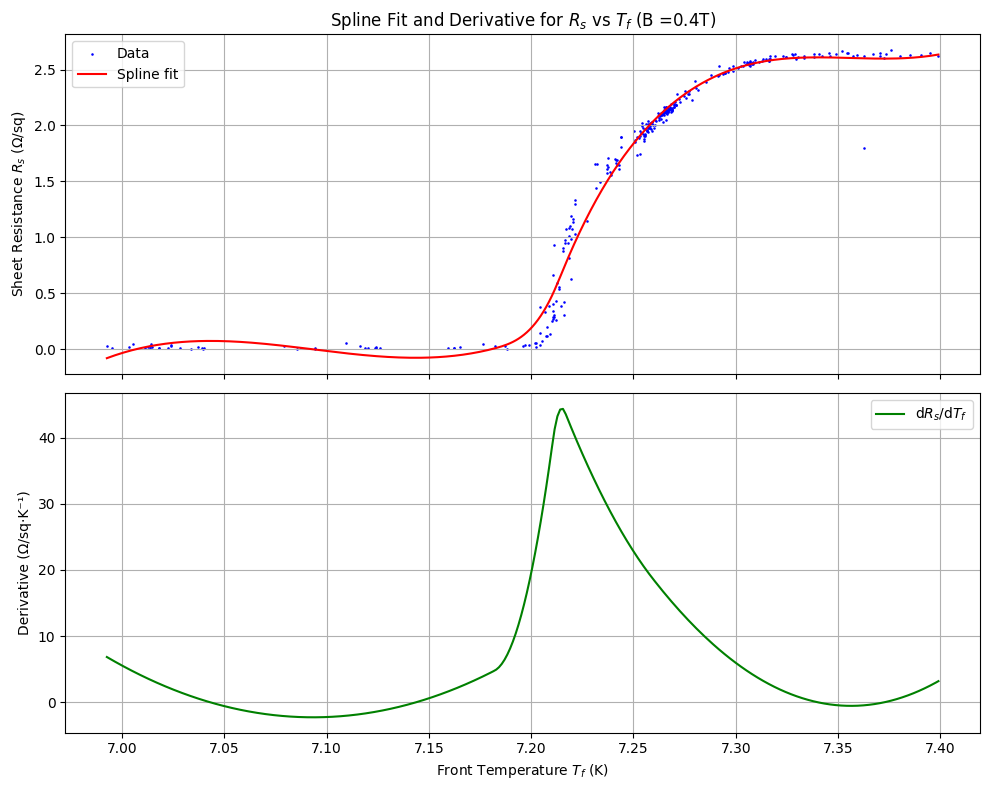

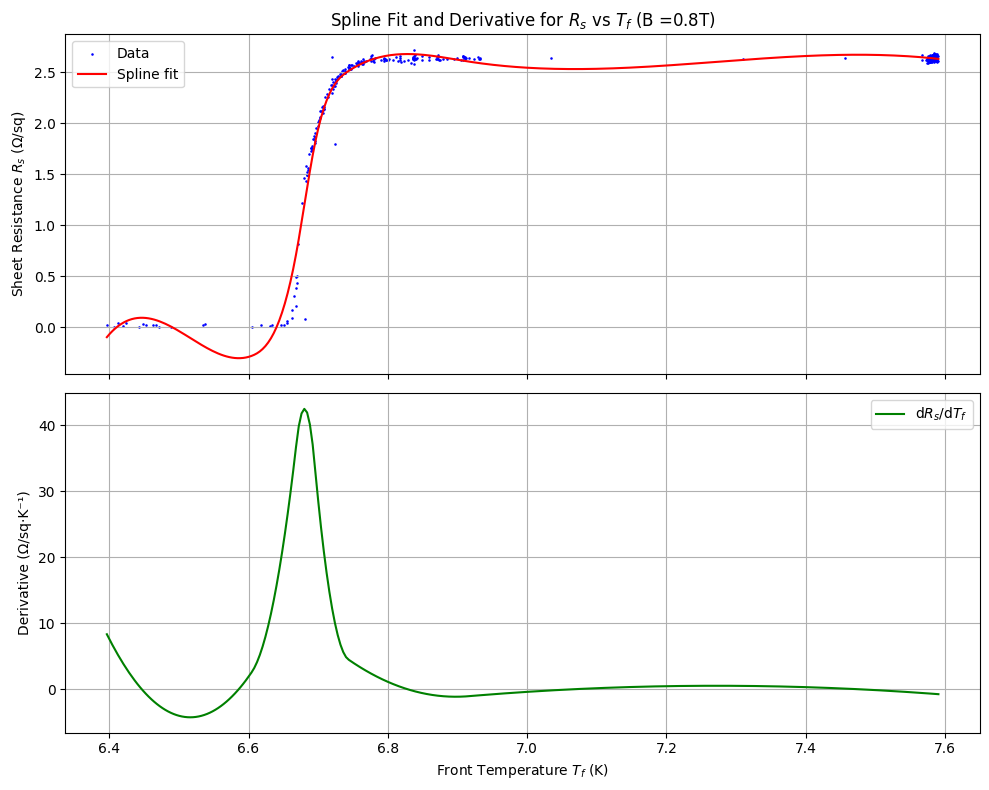

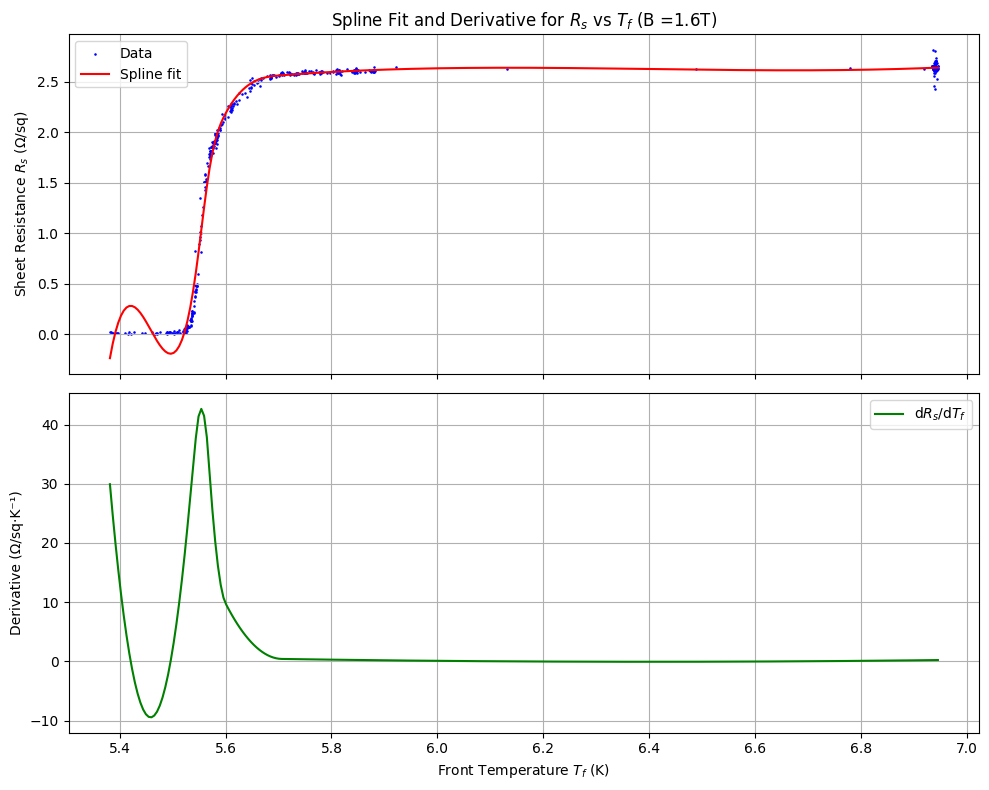

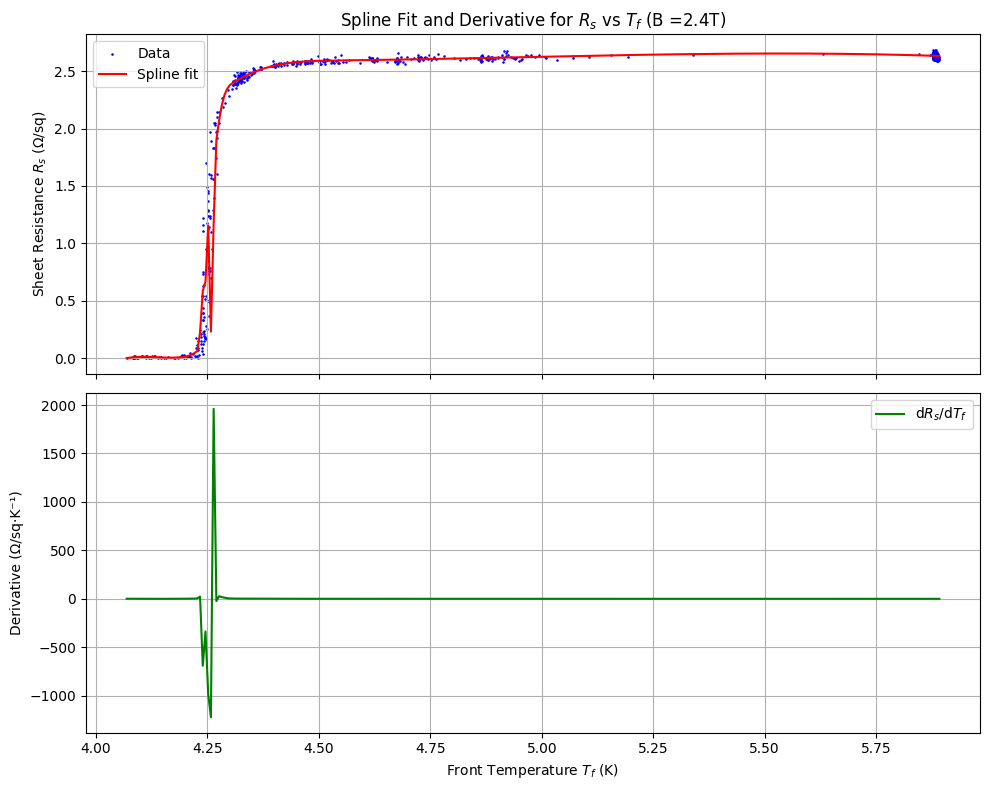

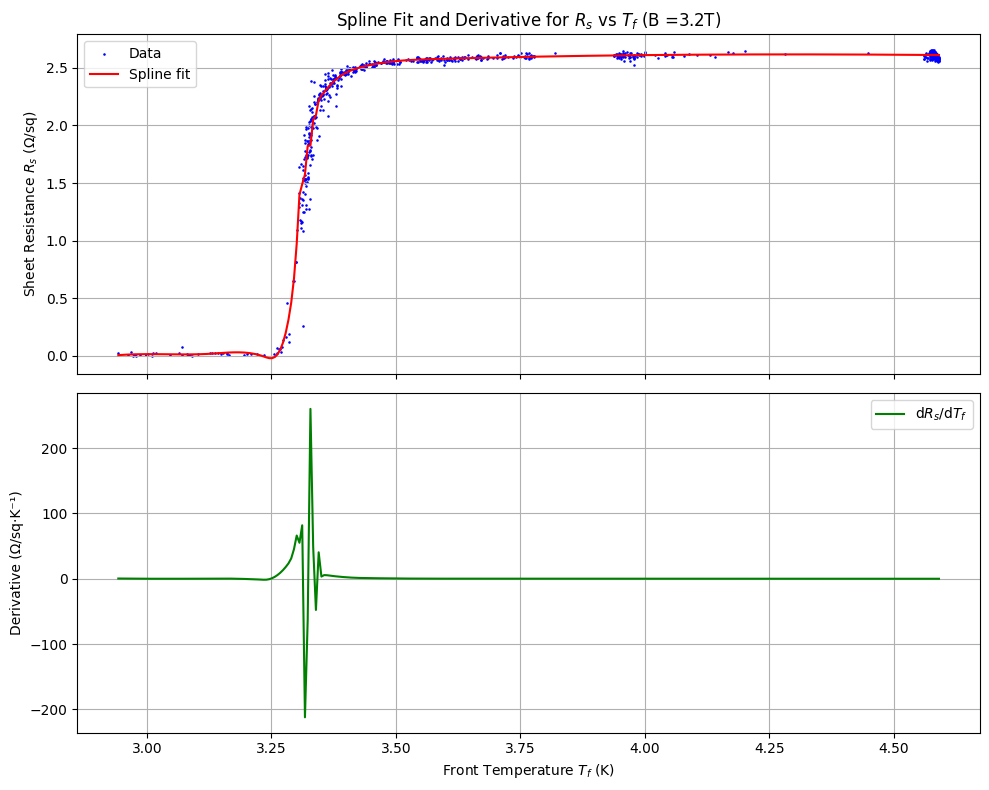

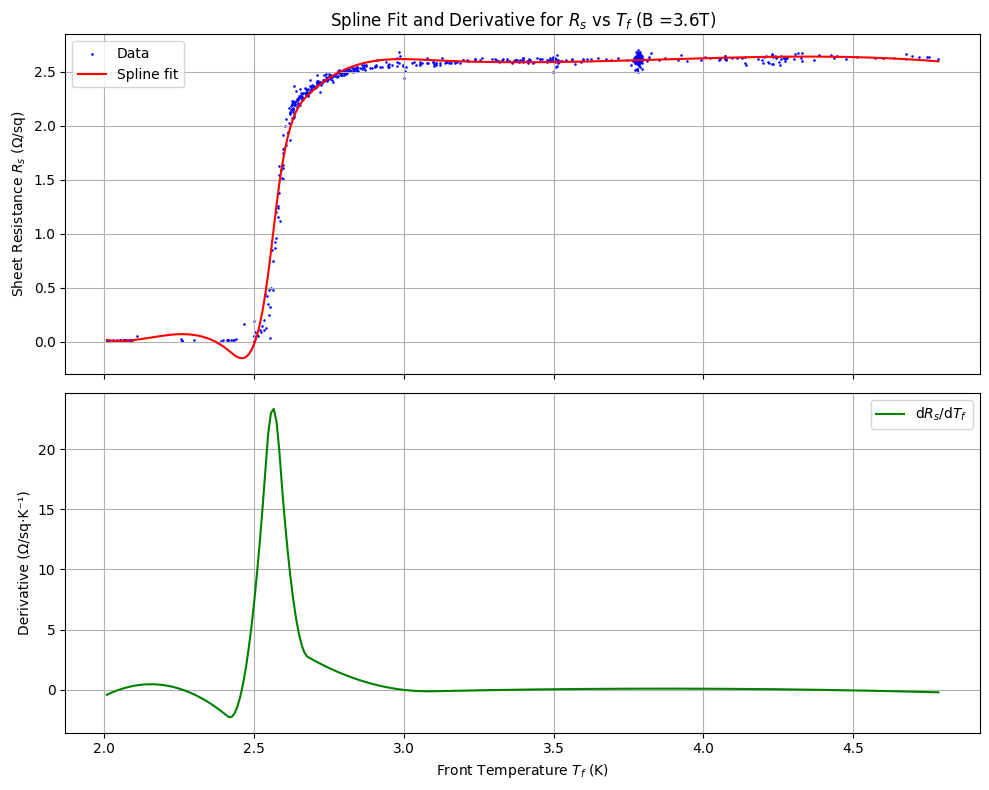

In [26]:
from scipy.interpolate import UnivariateSpline

for i, x in enumerate(B_vals):
    try:
        Tf = filtered_data[f'Tf_{x}']
        Rs = filtered_data[f'Rs_{x}']
    except KeyError:
        print(f"Missing data for x={x}, skipping...")
        continue

    if x == 0.4:
        mask_Tf_below_7_4 = Tf < 7.4
        Tf = Tf[mask_Tf_below_7_4]
        Rs = Rs[mask_Tf_below_7_4]

    sorted_indices = np.argsort(Tf)
    Tf_sorted = Tf[sorted_indices]
    Rs_sorted = Rs[sorted_indices]

    # Fit the smoothing spline
    spline = UnivariateSpline(Tf_sorted, Rs_sorted, s=4, k=3)

    # Evaluate the spline on a fine grid
    Tf_fine = np.linspace(Tf_sorted.min(), Tf_sorted.max(), 300)
    Rs_fine = spline(Tf_fine)

    # --- Compute first derivative ---
    spline_derivative = spline.derivative(n=1)
    Rs_derivative = spline_derivative(Tf_fine)

    # --- Plot ---
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot original data and spline
    ax[0].scatter(Tf, Rs, s=.7, color='blue', label="Data")
    ax[0].plot(Tf_fine, Rs_fine, color='red', label="Spline fit")
    ax[0].set_ylabel("Sheet Resistance $R_s$ (Ω/sq)")
    ax[0].set_title(f"Spline Fit and Derivative for $R_s$ vs $T_f$ (B ={x}T)")
    ax[0].legend()
    ax[0].grid(True)

    # Plot derivative
    ax[1].plot(Tf_fine, Rs_derivative, color='green', label="d$R_s$/d$T_f$")
    ax[1].set_xlabel("Front Temperature $T_f$ (K)")
    ax[1].set_ylabel("Derivative (Ω/sq·K⁻¹)")
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

## Sigmoid

Initial guesses: L=1.01, k=2.00, T0=7.22, C=0.00

Fitted parameters:
  L = 0.9703 +/- 0.0119
  k = 54.9281 +/- 1.6039
  T0 (Midpoint Tc) = 7.2336 +/- 0.0007 K
  C = 0.0000 +/- 0.0089
  T_50 (Tc) = 7.2336 K
  Tc Uncertainty ((T_90 - T_10) / 2) = 0.0400 K


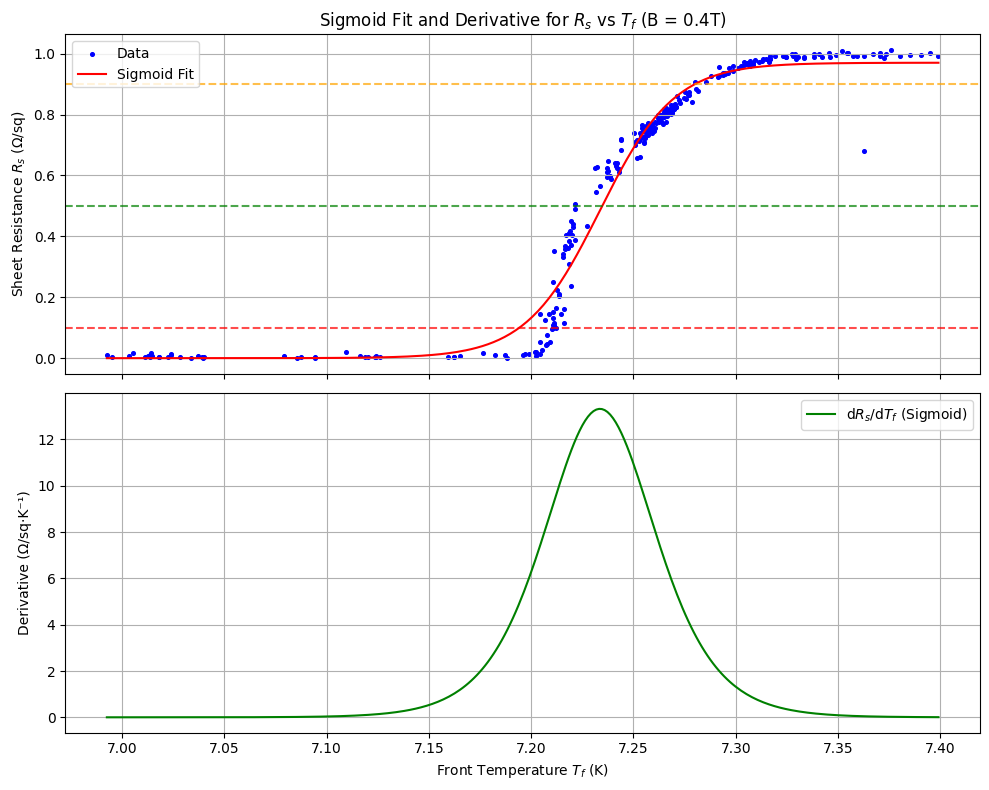

Initial guesses: L=1.03, k=2.00, T0=6.68, C=0.00

Fitted parameters:
  L = 0.9916 +/- 0.0084
  k = 76.3428 +/- 2.1285
  T0 (Midpoint Tc) = 6.6843 +/- 0.0004 K
  C = 0.0000 +/- 0.0080
  T_50 (Tc) = 6.6843 K
  Tc Uncertainty ((T_90 - T_10) / 2) = 0.0289 K


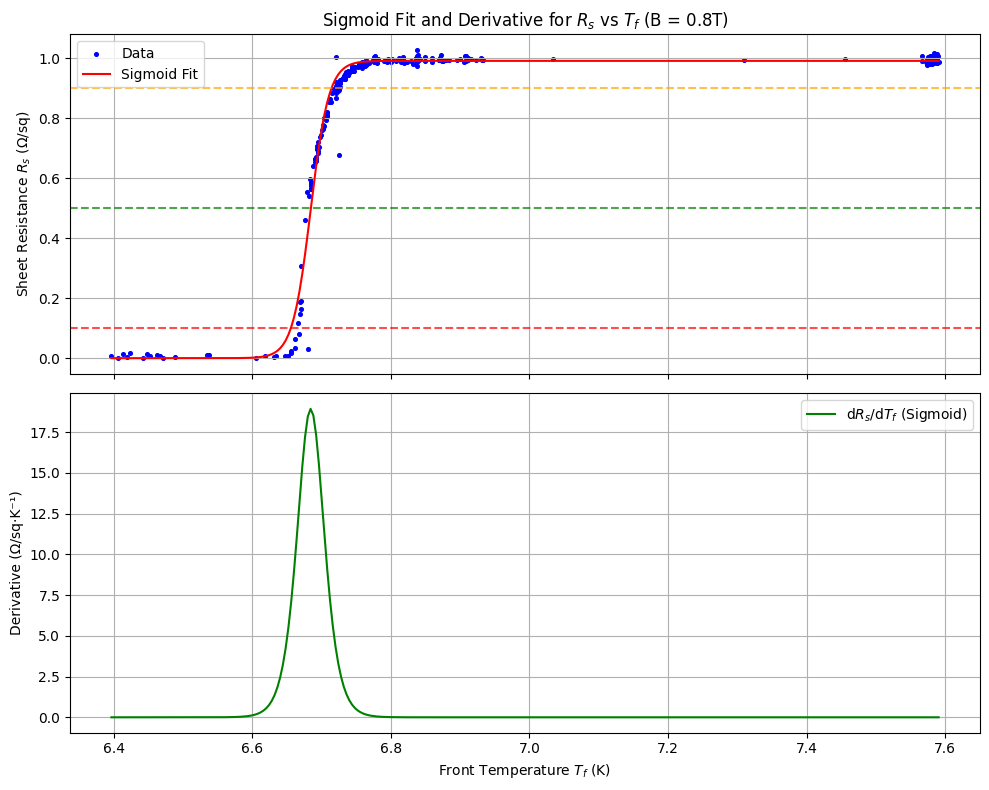

Initial guesses: L=1.07, k=2.00, T0=5.56, C=0.00

Fitted parameters:
  L = 0.9781 +/- 0.0075
  k = 70.3960 +/- 1.7334
  T0 (Midpoint Tc) = 5.5627 +/- 0.0004 K
  C = 0.0000 +/- 0.0069
  T_50 (Tc) = 5.5627 K
  Tc Uncertainty ((T_90 - T_10) / 2) = 0.0314 K


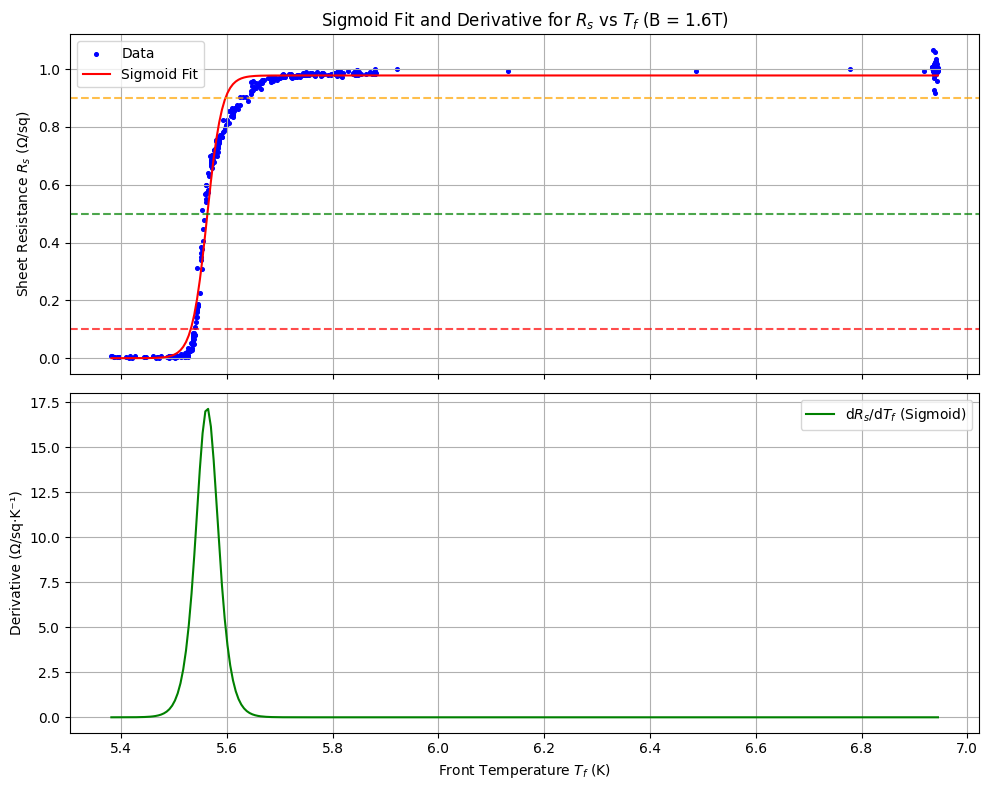

Initial guesses: L=1.02, k=2.00, T0=4.25, C=0.00

Fitted parameters:
  L = 0.9779 +/- 0.0075
  k = 87.9028 +/- 3.3246
  T0 (Midpoint Tc) = 4.2576 +/- 0.0004 K
  C = 0.0000 +/- 0.0070
  T_50 (Tc) = 4.2576 K
  Tc Uncertainty ((T_90 - T_10) / 2) = 0.0251 K


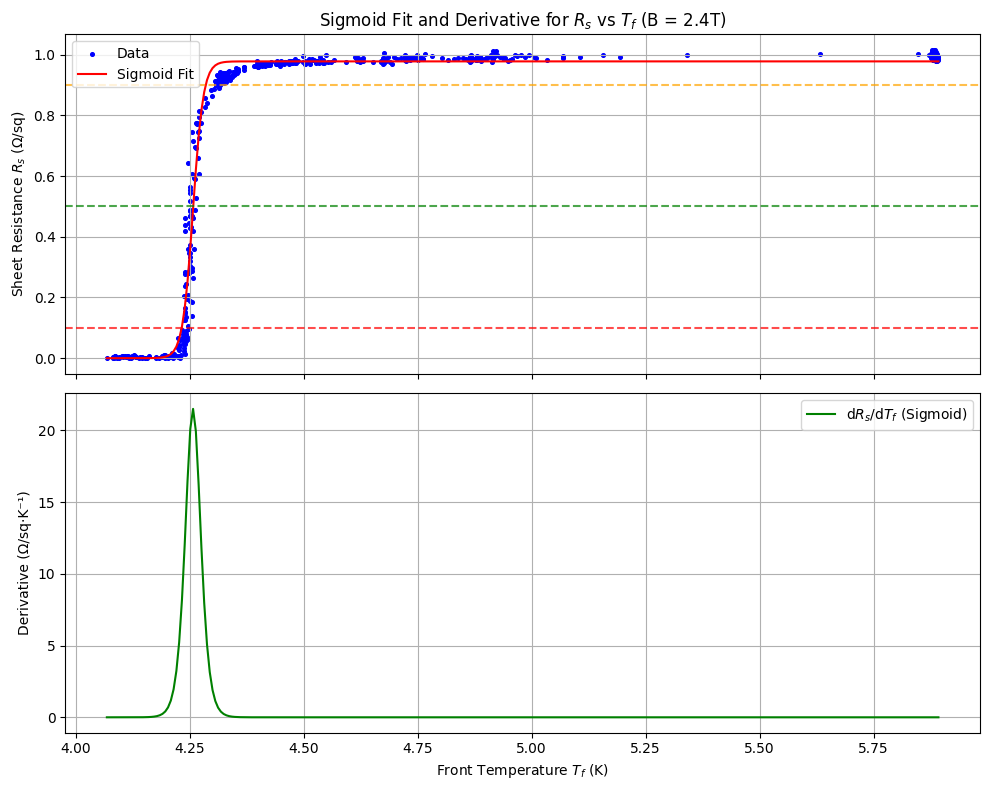

Initial guesses: L=1.00, k=2.00, T0=3.31, C=0.00

Fitted parameters:
  L = 0.9751 +/- 0.0064
  k = 51.7761 +/- 1.2133
  T0 (Midpoint Tc) = 3.3098 +/- 0.0005 K
  C = 0.0000 +/- 0.0061
  T_50 (Tc) = 3.3098 K
  Tc Uncertainty ((T_90 - T_10) / 2) = 0.0425 K


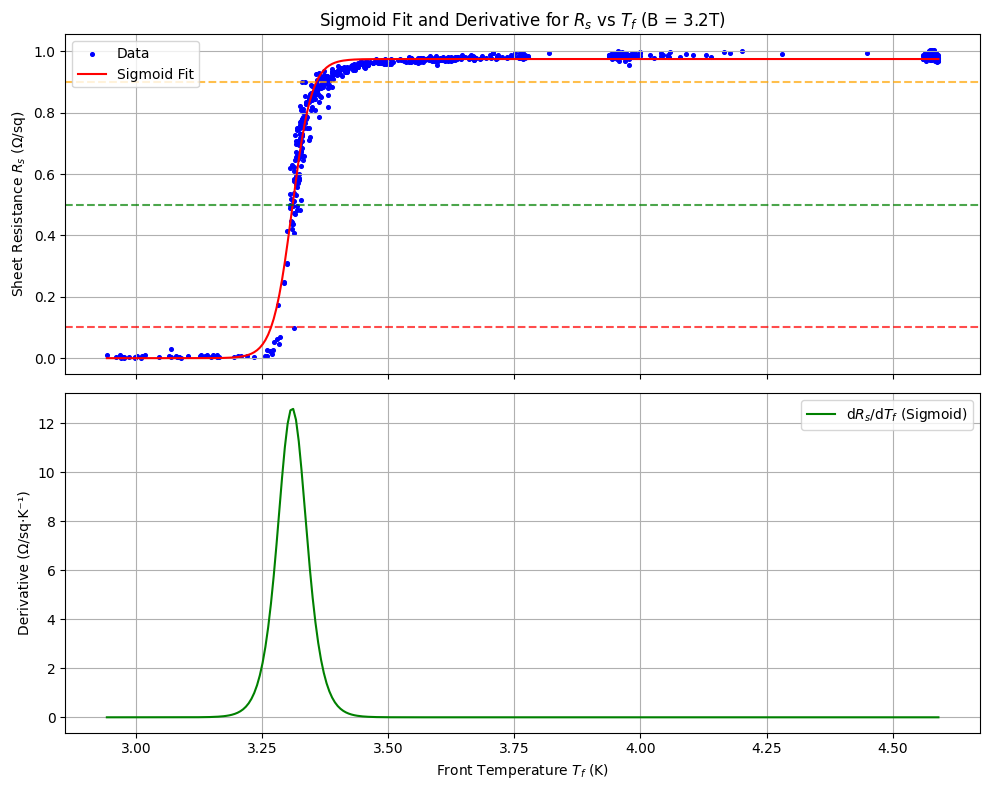

Initial guesses: L=1.02, k=2.00, T0=2.59, C=0.00

Fitted parameters:
  L = 0.9713 +/- 0.0051
  k = 36.6416 +/- 0.7736
  T0 (Midpoint Tc) = 2.5859 +/- 0.0007 K
  C = 0.0000 +/- 0.0048
  T_50 (Tc) = 2.5859 K
  Tc Uncertainty ((T_90 - T_10) / 2) = 0.0603 K


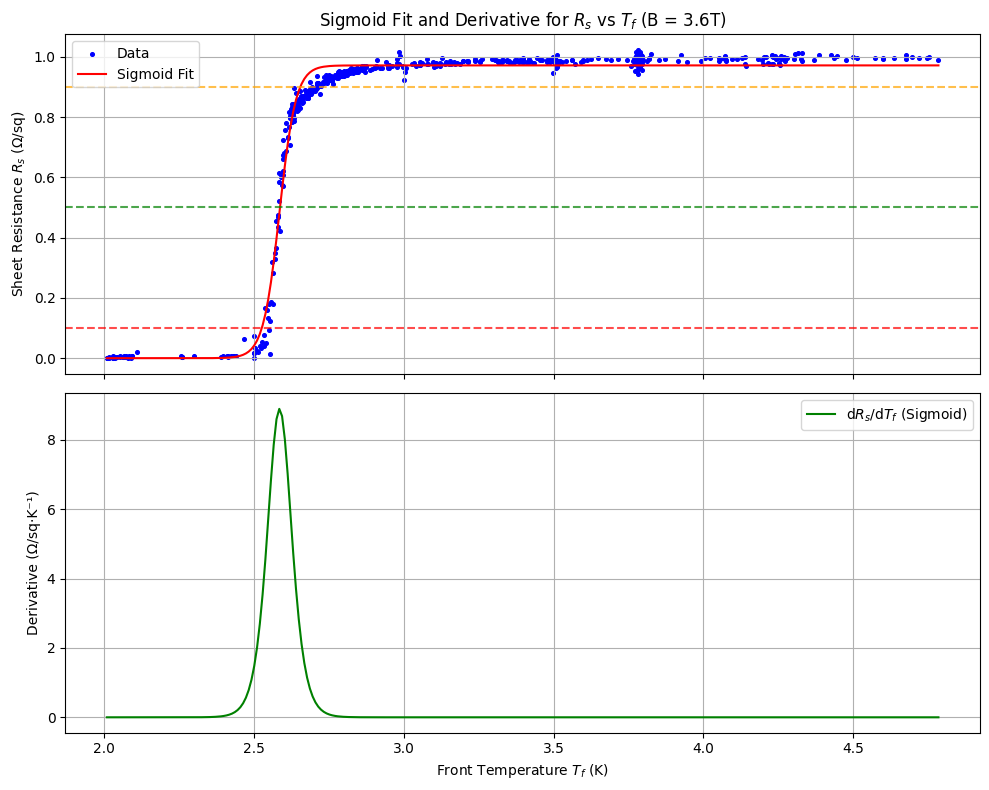

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline # Keep for comparison if desired


# Define the Sigmoid function
def sigmoid_function(T, L, k, T0, C):
    """
    Logistic Sigmoid function for fitting superconducting transition.
    T: Temperature
    L: Max resistance change (Amplitude from base to plateau)
    k: Steepness of the transition
    T0: Midpoint temperature (often taken as Tc)
    C: Minimum resistance (residual resistance)
    """
    return L / (1 + np.exp(-k * (T - T0))) + C


for i, x in enumerate(B_vals):
    try:
        Tf = filtered_data[f'Tf_{x}']
        Rs = filtered_data[f'Rs_{x}']
    except KeyError:
        print(f"Missing data for x={x}, skipping...")
        continue

    if x == 0.4:
        mask_Tf_below_7_4 = Tf < 7.4
        Tf = Tf[mask_Tf_below_7_4]
        Rs = Rs[mask_Tf_below_7_4]  

    sorted_indices = np.argsort(Tf)
    Tf_sorted = Tf[sorted_indices]
    Rs_sorted = Rs[sorted_indices]

    Rs_sorted = Rs_sorted / Rs_0

    # --- Initial Guess for Sigmoid Parameters ---
    # This is crucial for successful fitting. Adjust these based on your data's rough shape.
    # L_guess: roughly the difference between max and min resistance
    L_guess = np.max(Rs_sorted) - np.min(Rs_sorted)
    # T0_guess: temperature at roughly 50% of the transition
    T0_guess = Tf_sorted[np.argmin(np.abs(Rs_sorted - (np.min(Rs_sorted) + L_guess / 2)))]
    # k_guess: steepness. A positive value for increasing R with T.
    # Typically, a narrower transition means a larger k. Start with something like 2-5.
    k_guess = 2.0
    # C_guess: minimum resistance (value at lowest temperatures)
    C_guess = np.min(Rs_sorted)

    initial_guess = [L_guess, k_guess, T0_guess, C_guess]

    print(f"Initial guesses: L={L_guess:.2f}, k={k_guess:.2f}, T0={T0_guess:.2f}, C={C_guess:.2f}")

    try:
        # bounds: optional, to constrain parameters. e.g., (0, np.inf) for L and k
        # We want L, k > 0. T0 within temp range. C > 0 (or around 0).
        popt, pcov = curve_fit(sigmoid_function, Tf_sorted, Rs_sorted, p0=initial_guess,
                            bounds=([0, 0, Tf_sorted.min(), 0], [np.inf, np.inf, Tf_sorted.max(), np.inf]))

        L_fit, k_fit, T0_fit, C_fit = popt
        perr = np.sqrt(np.diag(pcov)) # Standard deviations of the parameters

        print(f"\nFitted parameters:")
        print(f"  L = {L_fit:.4f} +/- {perr[0]:.4f}")
        print(f"  k = {k_fit:.4f} +/- {perr[1]:.4f}")
        print(f"  T0 (Midpoint Tc) = {T0_fit:.4f} +/- {perr[2]:.4f} K")
        print(f"  C = {C_fit:.4f} +/- {perr[3]:.4f}")

        # Evaluate the fitted sigmoid on a fine grid
        Tf_fine_sigmoid = np.linspace(Tf_sorted.min(), Tf_sorted.max(), 300)
        Rs_fine_sigmoid = sigmoid_function(Tf_fine_sigmoid, *popt)

        # --- Compute first derivative of the Sigmoid fit ---
        # The derivative of L / (1 + e^(-k(T - T0))) + C is:
        # L * k * e^(-k(T - T0)) / (1 + e^(-k(T - T0)))^2
        def sigmoid_derivative(T, L, k, T0, C):
            exp_term = np.exp(-k * (T - T0))
            return L * k * exp_term / ((1 + exp_term)**2)

        Rs_derivative_sigmoid = sigmoid_derivative(Tf_fine_sigmoid, *popt)

    except RuntimeError as e:
        print(f"Error: Could not fit sigmoid function. {e}")
        L_fit, k_fit, T0_fit, C_fit = initial_guess # Use initial guess for plotting if fit fails
        Rs_fine_sigmoid = sigmoid_function(Tf_fine_sigmoid, *initial_guess)
        Rs_derivative_sigmoid = np.zeros_like(Tf_fine_sigmoid) # Placeholder if derivative fails


    # --- To get 10%, 50%, 90% thresholds from the Sigmoid fit ---
    # 1. Normalize the fitted Sigmoid curve
    # The maximum resistance in the normal state (Rs_0) for the sigmoid is approximately (L_fit + C_fit)
    # The minimum resistance is C_fit.
    # We normalize relative to the *total transition amplitude* (L_fit).
    # So, normalized_Rs = (Rs - C_fit) / L_fit

    if 'popt' in locals(): # Only proceed if fit was successful
        # Calculate the effective Rs_0 from the sigmoid fit: this is the normal state resistance
        Rs_normal_state_sigmoid = L_fit + C_fit

        # Create the normalized sigmoid curve
        Rs_norm_sigmoid_fine = (Rs_fine_sigmoid - C_fit) / (L_fit)

        # Now, use interp1d on the normalized sigmoid data
        # Ensure R_norm_sigmoid_fine is monotonically increasing (which it should be if k > 0)
        interp_func_sigmoid = interp1d(Rs_norm_sigmoid_fine, Tf_fine_sigmoid, kind='linear',
                                    bounds_error=False, fill_value='extrapolate')

        # Get the T values corresponding to the thresholds
        T_10_sigmoid = interp_func_sigmoid(threshold_10)
        T_50_sigmoid = interp_func_sigmoid(threshold_50)
        T_90_sigmoid = interp_func_sigmoid(threshold_90)

        #print(f"\nThresholds derived from Sigmoid Fit:")
        #print(f"  T_10 = {T_10_sigmoid:.4f} K")
        print(f"  T_50 (Tc) = {T_50_sigmoid:.4f} K") # T0_fit from Sigmoid is usually very close to this
        # print(f"  T_90 = {T_90_sigmoid:.4f} K")
        # print(f"  Transition Width (T_90 - T_10) = {(T_90_sigmoid - T_10_sigmoid):.4f} K")
        print(f"  Tc Uncertainty ((T_90 - T_10) / 2) = {((T_90_sigmoid - T_10_sigmoid) / 2):.4f} K")
    else:
        print("\nSigmoid fit failed, cannot calculate thresholds based on the fit.")


    # --- Plotting ---
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot original data and Sigmoid fit
    ax[0].scatter(Tf_sorted, Rs_sorted, s=7, color='blue', label="Data")
    ax[0].plot(Tf_fine_sigmoid, Rs_fine_sigmoid, color='red', label="Sigmoid Fit")
    ax[0].set_ylabel("Sheet Resistance $R_s$ (Ω/sq)")
    ax[0].set_title(f"Sigmoid Fit and Derivative for $R_s$ vs $T_f$ (B = {x}T)") # Using fixed B=2.4T for this example
    ax[0].legend()
    ax[0].grid(True)

    ax[0].axhline(y=threshold_10, color='r', linestyle='--', alpha=0.7, label='10%')
    ax[0].axhline(y=threshold_50, color='g', linestyle='--', alpha=0.7, label='50%')
    ax[0].axhline(y=threshold_90, color='orange', linestyle='--', alpha=0.7, label='90%')
    # ax_r.axvline(x=T_10, color='r', linestyle=':', alpha=0.7)
    # ax_r.axvline(x=T_50, color='g', linestyle=':', alpha=0.7)
    # ax_r.axvline(x=T_90, color='orange', linestyle=':', alpha=0.7)

    # Plot derivative of Sigmoid
    ax[1].plot(Tf_fine_sigmoid, Rs_derivative_sigmoid, color='green', label="d$R_s$/d$T_f$ (Sigmoid)")
    ax[1].set_xlabel("Front Temperature $T_f$ (K)")
    ax[1].set_ylabel("Derivative (Ω/sq·K⁻¹)")
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

## **Fermi-Dirac like function**

In [28]:
from scipy.optimize import curve_fit

Rho_0 = 2.6427

# Fermi-Dirac like function for superconducting transition
def FD_model(T, T_c, delta_T):
    return Rho_0 / (1 + np.exp(-(T - T_c) / delta_T))

def dR_dT_FD(T, T_c, delta_T):
    exp_term = np.exp(-(T - T_c) / delta_T)
    return (Rho_0 / delta_T) * (exp_term / (1 + exp_term)**2)

# Get filtered Tf and Rs data 
Tf = filtered_data['Tf_3.6']
Rs = filtered_data['Rs_3.6']

# Sort
sorted_idx = np.argsort(Tf)
Tf_sorted = Tf[sorted_idx]
Rs_sorted = Rs[sorted_idx]  # Normalize Rs by Rs_0

# Fit
popt, _ = curve_fit(FD_model, Tf_sorted, Rs_sorted, p0=[Tf_sorted[np.argmax(np.gradient(-Rs))], 0.1])
T_c_fit, delta_T_fit = popt

# Evaluate model
Tf_fit = np.linspace(Tf_sorted.min(), Tf_sorted.max(), 500)
Rs_fit = FD_model(Tf_fit, *popt)

#DERIVATIVE
dRs_numeric = np.gradient(Rs_fit, Tf_fit) #numerical gradient to camper with the fit
# Remove NaNs or infs from both arrays
valid_mask = np.isfinite(dRs_numeric) & np.isfinite(Tf_fit)
Tf_valid = Tf_fit[valid_mask]
dRs_numeric_valid = dRs_numeric[valid_mask]


popt_dR, _ = curve_fit(dR_dT_FD, Tf_valid, dRs_numeric_valid, p0=popt)
dRs_fit = dR_dT_FD(Tf_valid, *popt_dR )

print('Tc (from derivative fit):', popt_dR[0])



Tc (from derivative fit): 2.588185399417631


In [29]:
# find FWHM = Tc(90%) + Tc(10%) 
T_fwhm=[]
for i in range(len(Rs_fit)): 
    if(dRs_fit[i]>np.max(dRs_fit)/2): T_fwhm.append(Tf_fit[i])
FWHM = np.max(T_fwhm)-np.min(T_fwhm)

print(FWHM)

0.10005875350701432


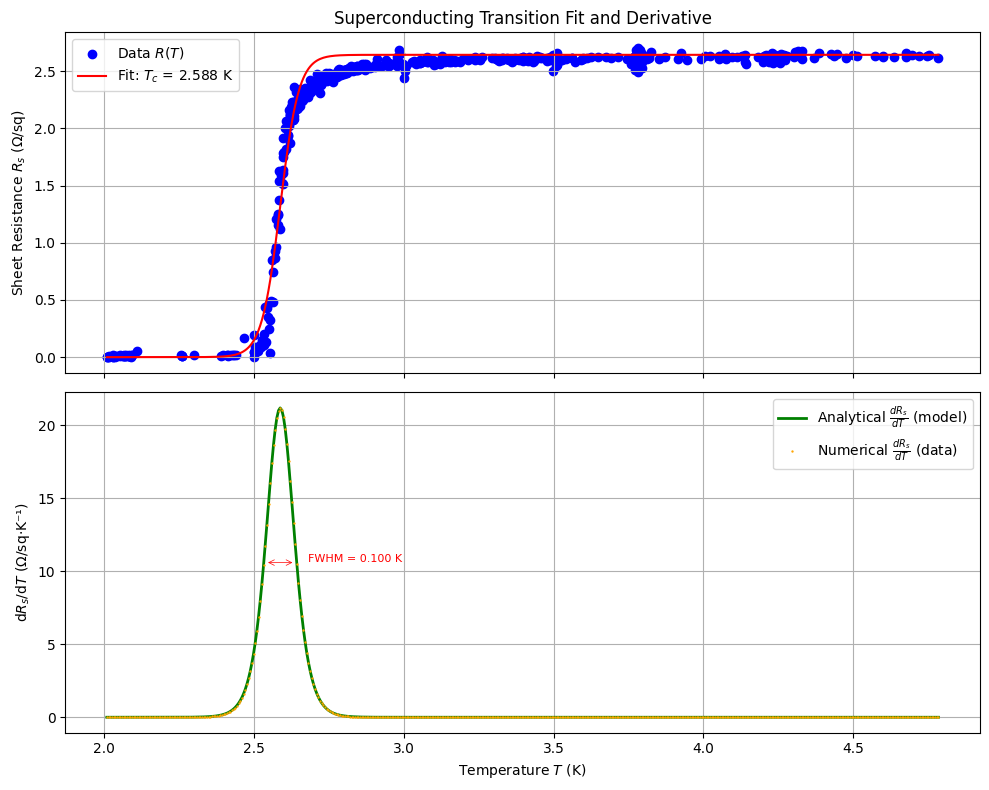

In [30]:


# Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# R(T) and fit 
ax[0].scatter(Tf_sorted, Rs_sorted, label="Data $R(T)$", color='blue')
ax[0].plot(Tf_fit, Rs_fit, label=f"Fit: $T_c$ = {T_c_fit:.3f} K", color='red')
ax[0].set_ylabel("Sheet Resistance $R_s$ (Ω/sq)")
ax[0].set_title("Superconducting Transition Fit and Derivative")
ax[0].legend()
ax[0].grid(True)

# dR/dT and model derivative
label_text = f"FWHM = {FWHM:.3f} K"

# Draw the double arrow using annotate
ax[1].annotate(
    '', 
    xy=(T_c_fit - FWHM/2 + FWHM, np.max(dRs_fit)/2), 
    xytext=(T_c_fit - FWHM/2, np.max(dRs_fit)/2), 
    arrowprops=dict(arrowstyle='<->', color='red', linewidth=.5)
)

# Place the label in the middle of the arrow
x_mid = T_c_fit 
ax[1].text(x_mid+FWHM/2+.2, np.max(dRs_fit)/2-.1 , label_text, ha='center', va='bottom', fontsize=8, color='red')


ax[1].plot(Tf_valid, dRs_fit, label=r"Analytical $\frac{dR_s}{dT}$ (model)", color='green', linewidth=2)
ax[1].plot(Tf_fit, dRs_numeric, 'o', label=r"Numerical $\frac{dR_s}{dT}$ (data)", color='orange', markersize=.7)
#ax[1].plot([T_c_fit - FWHM/2, T_c_fit + FWHM/2], [np.max(dRs_fit)/2, np.max(dRs_fit)/2], color='black', linewidth=2)
ax[1].set_xlabel("Temperature $T$ (K)")
ax[1].set_ylabel("d$R_s$/d$T$ (Ω/sq·K⁻¹)")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

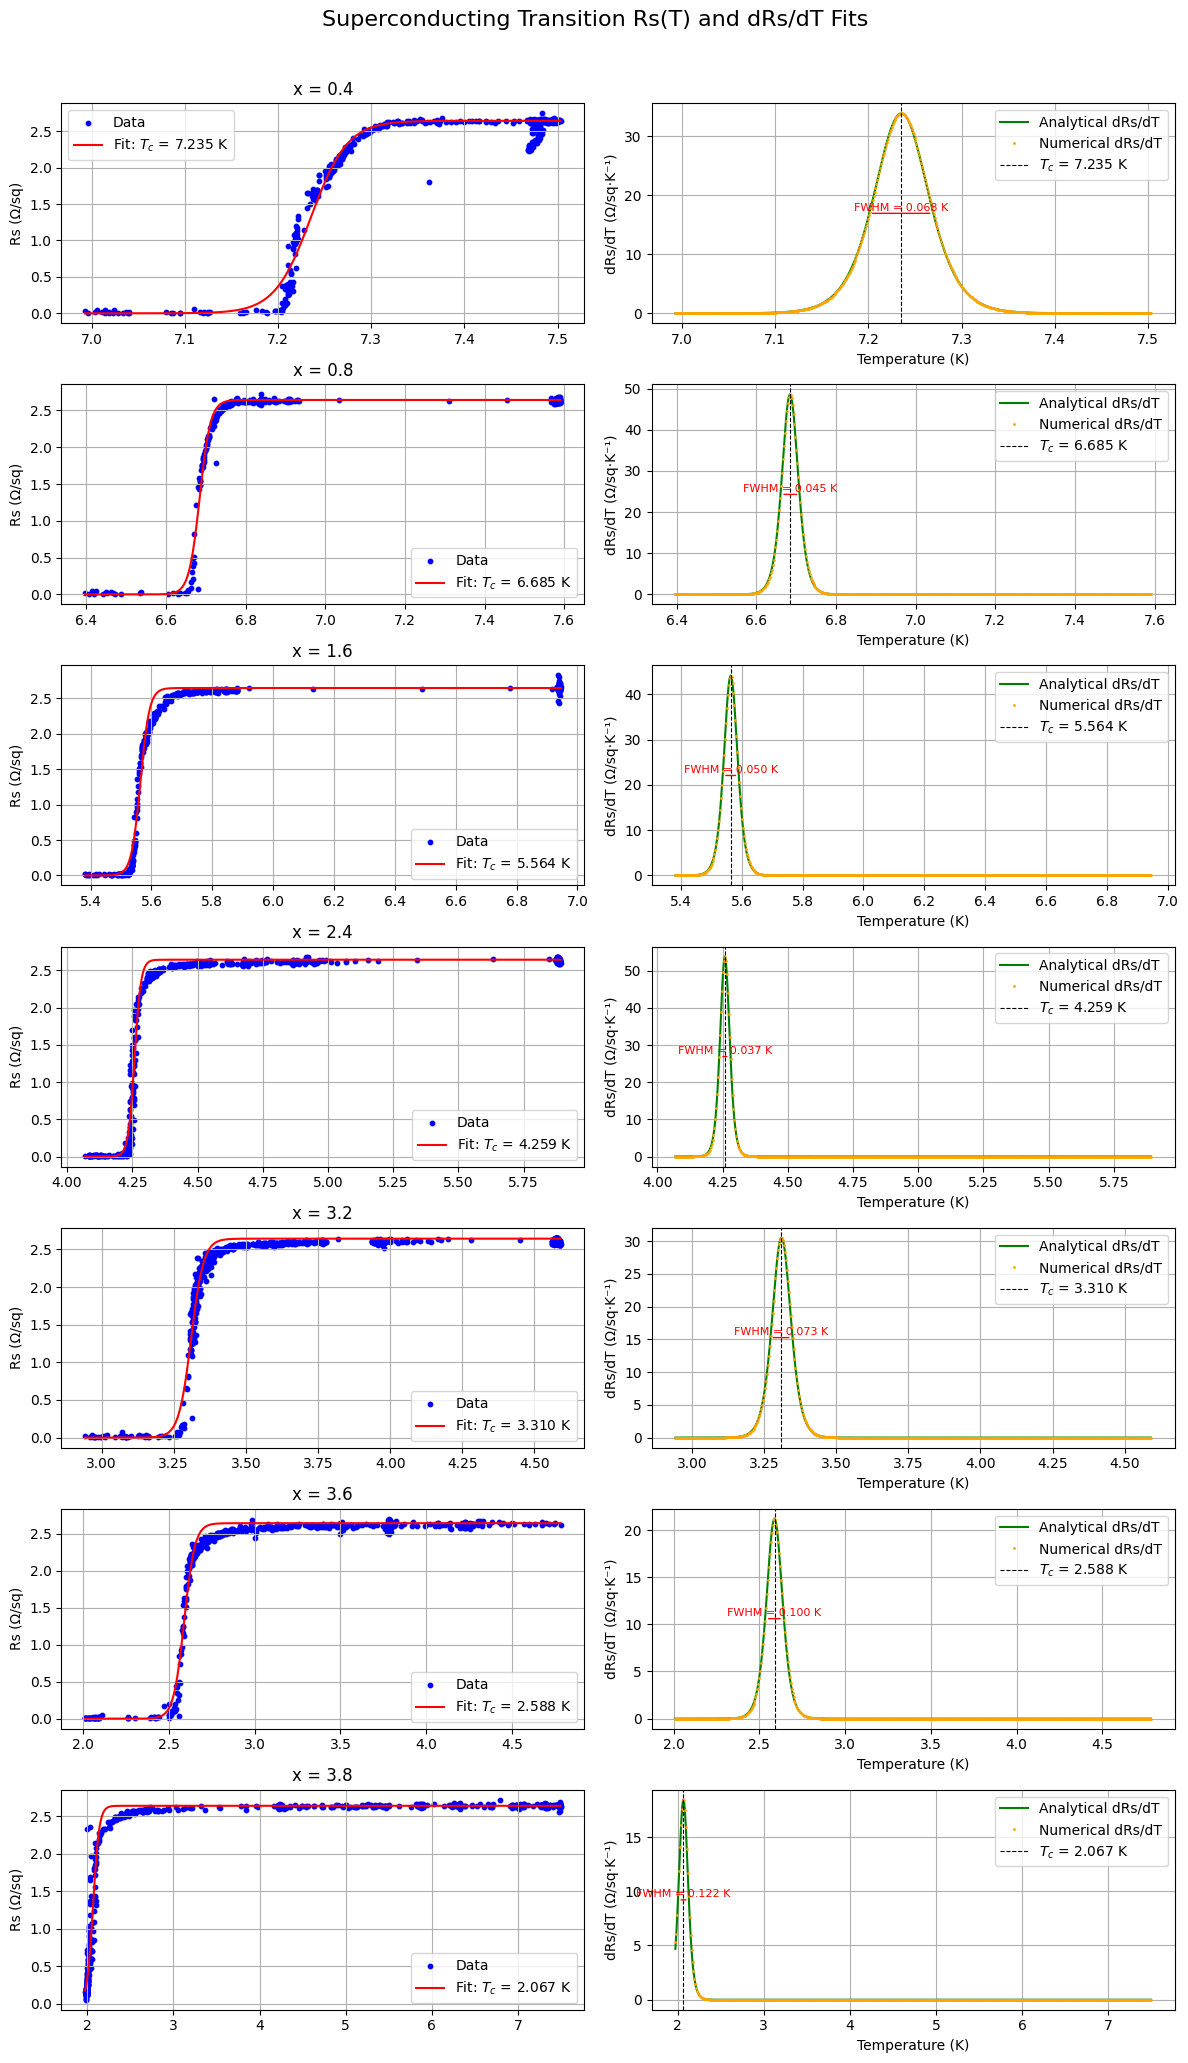

In [31]:
# --- X values from your original dataset names ---
x_vals = [0.4, 0.8, 1.6, 2.4, 3.2, 3.6, 3.8]

# --- Plotting ---
fig, axs = plt.subplots(len(x_vals), 2, figsize=(12, 3 * len(x_vals)), sharex=False)
fig.suptitle("Superconducting Transition Rs(T) and dRs/dT Fits", fontsize=16)

for i, x in enumerate(x_vals):
    try:
        Tf = filtered_data[f'Tf_{x}']
        Rs = filtered_data[f'Rs_{x}']
    except KeyError:
        print(f"Missing data for x={x}, skipping...")
        continue

    # Sort
    sorted_idx = np.argsort(Tf)
    Tf_sorted = Tf[sorted_idx]
    Rs_sorted = Rs[sorted_idx]

    # Initial guess for Tc: where -dR/dT peaks
    guess_Tc = Tf_sorted[np.argmax(np.gradient(-Rs_sorted))]
    try:
        popt, _ = curve_fit(FD_model, Tf_sorted, Rs_sorted, p0=[guess_Tc, 0.1])
        T_c_fit, delta_T_fit = popt
    except RuntimeError:
        print(f"Fit did not converge for x={x}")
        continue

    # Evaluate Rs(T) model
    Tf_fit = np.linspace(Tf_sorted.min(), Tf_sorted.max(), 500)
    Rs_fit = FD_model(Tf_fit, *popt)

    # Numerical derivative
    dRs_numeric = np.gradient(Rs_fit, Tf_fit)

    # Remove NaNs/infs
    valid_mask = np.isfinite(dRs_numeric) & np.isfinite(Tf_fit)
    Tf_valid = Tf_fit[valid_mask]
    dRs_numeric_valid = dRs_numeric[valid_mask]

    # Fit dR/dT model (optional — or just use analytical version)
    try:
        popt_dR, _ = curve_fit(dR_dT_FD, Tf_valid, dRs_numeric_valid, p0=popt)
        dRs_fit = dR_dT_FD(Tf_valid, *popt_dR)
    except RuntimeError:
        dRs_fit = dR_dT_FD(Tf_valid, *popt)

    # --- FWHM Calculation ---
    half_max = np.max(dRs_fit) / 2
    T_fwhm = Tf_valid[dRs_fit > half_max]
    FWHM = T_fwhm.max() - T_fwhm.min() if len(T_fwhm) > 1 else np.nan

    # --- Plot Rs(T) ---
    ax_r = axs[i, 0]
    ax_r.scatter(Tf_sorted, Rs_sorted, color='blue', s=10, label="Data")
    ax_r.plot(Tf_fit, Rs_fit, color='red', label=f"Fit: $T_c$ = {T_c_fit:.3f} K")
    ax_r.set_ylabel("Rs (Ω/sq)")
    ax_r.set_title(f"x = {x}")
    ax_r.legend()
    ax_r.grid(True)

    # --- Plot dRs/dT ---
    ax_d = axs[i, 1]
    ax_d.plot(Tf_valid, dRs_fit, label="Analytical dRs/dT", color='green')
    ax_d.plot(Tf_valid, dRs_numeric_valid, '.', label="Numerical dRs/dT", color='orange', markersize=2)


    filtered_data[f'T_{x}'] = [ T_c_fit, delta_T_fit] 

    # Draw FWHM arrow
    ax_d.annotate(
        '',
        xy=(T_fwhm.min(), half_max),
        xytext=(T_fwhm.max(), half_max),
        arrowprops=dict(arrowstyle='-', color='red', linewidth=1)
    )
    ax_d.text((T_fwhm.min() + T_fwhm.max()) / 2, half_max + 0.1, f"FWHM = {FWHM:.3f} K", 
              ha='center', va='bottom', fontsize=8, color='red')

    ax_d.axvline(T_c_fit, color='black', linestyle='--', linewidth=0.8, label=f"$T_c$ = {T_c_fit:.3f} K")
    ax_d.set_xlabel("Temperature (K)")
    ax_d.set_ylabel("dRs/dT (Ω/sq·K⁻¹)")
    ax_d.grid(True)
    ax_d.legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

[0.01949019 0.01355006 0.01491396 0.01218742 0.02158747 0.03108301
 0.03536438]


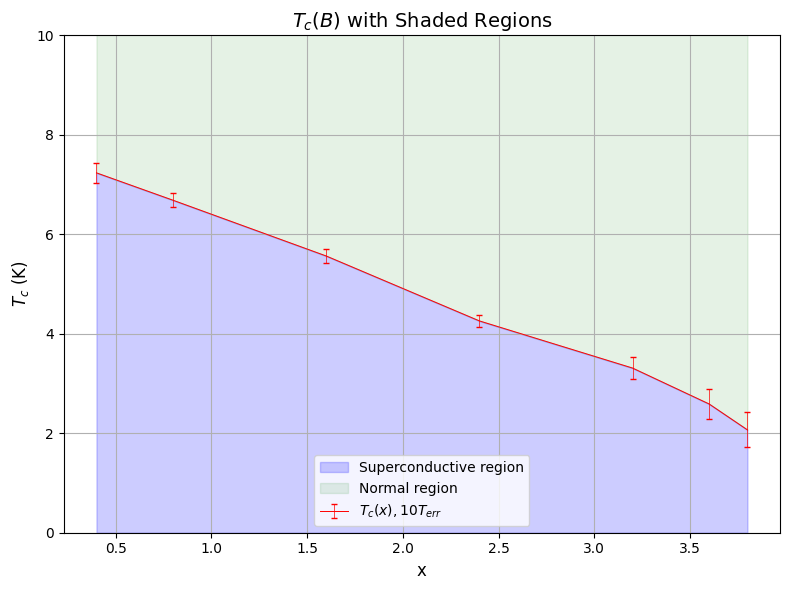

In [32]:
# Extract x and Tc_fit values from filtered_data
x_vals = []
Tc_vals = []
T_err = []


for x in [0.4, 0.8, 1.6, 2.4, 3.2, 3.6, 3.8]:
    T_range = filtered_data.get(f'T_{x}')
    if T_range:
        x_vals.append(x)
        Tc_vals.append(T_range[0])
        T_err.append(T_range[1])

# Convert to arrays for plotting
x_vals = np.array(x_vals)
Tc_vals = np.array(Tc_vals)
T_err = np.array(T_err)

# Sort for correct plotting
sorted_idx = np.argsort(x_vals)
x_vals = x_vals[sorted_idx]
Tc_vals = Tc_vals[sorted_idx]
T_err = T_err[sorted_idx]
print(T_err)

# Plot Tc(x) curve
plt.figure(figsize=(8, 6))
plt.errorbar(
    x_vals, Tc_vals, yerr=10*T_err,
    fmt='-', color='red', linewidth=.7,
    capsize=2, elinewidth=.5, label="$T_c(x), 10T_{err}$"
)
# plt.plot(x_vals, T_10_vals, '--', color = 'orange', linewidth=.5, label="$T_{10}(x)$")
# plt.plot(x_vals, T_90_vals, '--', color = 'orange', linewidth=.5, label="$T_{90}(x)$")


# Fill green below the Tc(x) curve
plt.fill_between(x_vals, 0, Tc_vals, color='blue', alpha=0.2, label="Superconductive region")

# Fill green above the Tc(x) curve (up to max of Tc + margin)
T_max = Tc_vals.max() + 5
plt.fill_between(x_vals, Tc_vals, T_max, color='green', alpha=0.1, label="Normal region")

# Labels and formatting
plt.xlabel("x", fontsize=12)
plt.ylabel("$T_c$ (K)", fontsize=12)
plt.title("$T_c(B)$ with Shaded Regions", fontsize=14)
plt.ylim(0, 10)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()